# Initial experiments for the flight path optimization

## Imports

In [1]:
# This magic makes plots appear in the browser
%matplotlib inline
import matplotlib.pyplot as plt

import firedrake as fd
from scipy import sparse
import numpy as np
import time

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
tStart_notebook = time.time()

In [3]:
meshDim = 50

In [4]:
class FOM_advectiondiffusion:
    def __init__(
        self, meshDim = 50,
        polyDim = 1,
        bool_mpi = False,
        kappa = 1e-3,
        dt = 0.1,
        final_time = 4,
        **kwargs):

        # MPI info
        self.bool_mpi = bool_mpi

        # Discretization
        self.mesh = self.create_mesh(meshDim)
        self.boundary_marker = self.create_boundary_marker()
        self.velocity = self.create_velocity_field()  # for advection term
        self.V = fd.FunctionSpace(self.mesh, 'P', degree = polyDim)  # Trial and test space for advection-diffusion eq
        self.nFE = self.V.dim()  # FE dimension

        # True initial condition
        x, y = fd.SpatialCoordinate(self.mesh)
        self.m_true = fd.Function(self.V).interpolate(
            fd.exp(-100 * (pow(x - 0.35, 2)  + pow(y - 0.7, 2)))
        )

        # Equation setup
        self.kappa = kappa
        self.dt = dt
        self.final_time = final_time

        # Important Matrices
        self.M = self.mass_matrix()
        self.I = self.inner_product_matrix()

        self.set_defaults(**kwargs)

    def set_defaults(self, **kwargs):
        return

    def inner_product_matrix(self):
        u = fd.TrialFunction(self.V)
        v = fd.TestFunction(self.V)
        a = fd.inner(fd.grad(u), fd.grad(v)) * fd.dx

        A = fd.assemble(a)
        A = fd.as_backend_type(A).mat()  # PETSc matrix
        # A = sparse.csr_matrix(A.getValueCSR()[::-1], shape = A.size)
        return A + self.M

    def apply_inner_product(self, u, v):
        return self.apply_mass_matrix(u, v) + fd.assemble(fd.inner(fd.grad(u), fd.grad(v)) * fd.dx)

    def mass_matrix(self):
        u = fd.TrialFunction(self.V)
        v = fd.TestFunction(self.V)

        a = fd.inner(u, v) * fd.dx

        A = fd.assemble(a)
        A = fd.as_backend_type(A).mat()  # PETSc matrix
        # return sparse.csr_matrix(A.getValuesCSR()[::-1], shape=A.size)
        return A


    def apply_mass_matrix(self, u, v):
        return fd.assemble(fd.inner(u, v) * fd.dx)

    def create_mesh(self, meshDim):
        """Dummy mesh until I can get a better mesh working"""
        return fd.UnitSquareMesh(meshDim,meshDim)

    def create_boundary_marker(self):
        # not implemented right now
        return

    def create_velocity_field(self):
        """Dummy boundary conditions for dummy mesh"""
        mesh = self.mesh

        P2 = fd.VectorElement("P", mesh.ufl_cell(), 2)
        P1 = fd.FiniteElement("P", mesh.ufl_cell(), 1)
        TH = fd.MixedElement([P2, P1])

        W = fd.FunctionSpace(mesh, TH)

        bc_left = fd.DirichletBC(W.sub(0), (0, 1), 1)
        bc_right = fd.DirichletBC(W.sub(0), (0, -1), 2)
        bc_bottom = fd.DirichletBC(W.sub(0), (0, 0), 3)
        bc_top = fd.DirichletBC(W.sub(0), (0, 0), 4)
        bcW = [bc_left, bc_right, bc_top, bc_bottom]

        v, q = fd.TestFunctions(W)
        w = fd.Function(W)
        u, p = fd.split(w)

        # Define the variational forms
        F = fd.Constant(1 / 50) * fd.inner(fd.grad(u), fd.grad(v)) * fd.dx \
            + fd.dot(fd.dot(fd.grad(u), u), v) * fd.dx \
            - p * fd.div(v) * fd.dx - q * fd.div(u) * fd.dx

        # Solve the problem
        fd.solve(F == 0, w, bcW)
        return u

    def plot(self, u):
        plt.figure()
        c = fd.plot(u, mesh = self.mesh)
        plt.colorbar(c)

    def find_next(self, u_old, dt, kappa):
        u = fd.Function(self.V)
        v = fd.TestFunction(self.V)

        F = fd.inner(u, v) * fd.dx
        F = F - fd.inner(u_old, v) * fd.dx
        F = F + fd.Constant(dt * self.kappa) * fd.inner(fd.grad(u), fd.grad(v)) * fd.dx
        F = F + fd.Constant(dt) * fd.inner(v *self.velocity, fd.grad(u)) * fd.dx

        fd.solve(F == 0, u)

        return u

    def implicit_Euler(self, m_init, dt = None, final_time = None,
                       kappa = None, grid_t = None):
        if grid_t is None:
            if dt is None: dt = self.dt
            if final_time is None: final_time = self.final_time
            if kappa is None: kappa = self.kappa
            grid_t = np.linspace(0, 4, int(final_time/ dt + 1))

        sol = np.empty(grid_t.shape, dtype = object)
        sol[0] = fd.Function(self.V)
        sol[0].interpolate(m_init)

        for k in range(1, sol.shape[0]):
            sol[k] = self.find_next(sol[k-1], dt = grid_t[k] - grid_t[k-1],
                                   kappa = kappa)
        return sol, grid_t

    def assemble_initial_condition(self, para):
        return para[0] * self.m_true

    def solve(self, para, grid_t=None):
        m_init = self.assemble_initial_condition(para)
        return self.implicit_Euler(m_init = m_init, grid_t = grid_t)


In [5]:
class FOM_advectiondiffusion_steadystate(FOM_advectiondiffusion):
    default_forcing = None
    default_para = None

    def set_defaults(self, **kwargs):
        self.default_forcing = self.m_true
        self.default_para = [0.1, 20, 0.01]

    def solve_steady(self, forcing = None, para = None):

        forcing = forcing if forcing is not None else self.default_forcing
        para = para if para is not None else self.default_para

        u = fd.TrialFunction(self.V)
        v = fd.TestFunction(self.V)
        sol = fd.Function(self.V)

        a = para[0] * fd.inner(fd.grad(u), fd.grad(v)) * fd.dx
        a = a + para[1] * fd.inner(v * self.velocity, fd.grad(u)) * fd.dx
        a = a + para[2] * fd.inner(u, v) * fd.dx

        f = fd.inner(forcing, v) * fd.dx

        bc_left = fd.DirichletBC(self.V, 0, 1)
        bc_right = fd.DirichletBC(self.V, 0, 2)
        bc_bottom = fd.DirichletBC(self.V, 0, 3)
        bc_top = fd.DirichletBC(self.V, 0, 4)
        bcs = [bc_left, bc_right, bc_bottom, bc_top]

        fd.solve(a == f, sol, bcs)
        return sol

    def assemble_forcing(self, para):
        return para[0] * self.default_forcing

    def solve(self, para, grid_t=None):
        forcing = self.assemble_forcing(para)
        return self.solve_steady(forcing=forcing), grid_t


In [6]:
fom = FOM_advectiondiffusion_steadystate(meshDim = meshDim)
fom_transient = FOM_advectiondiffusion(meshDim = meshDim)

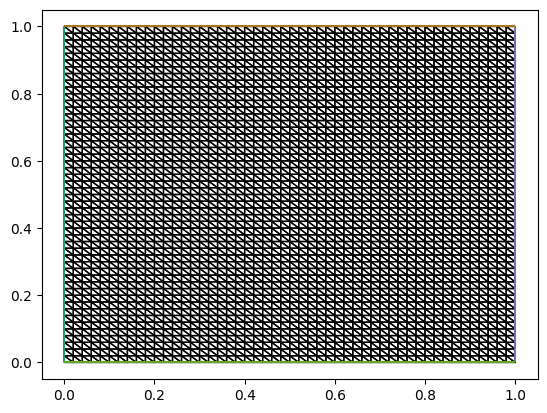

In [7]:
fd.triplot(fom.mesh)

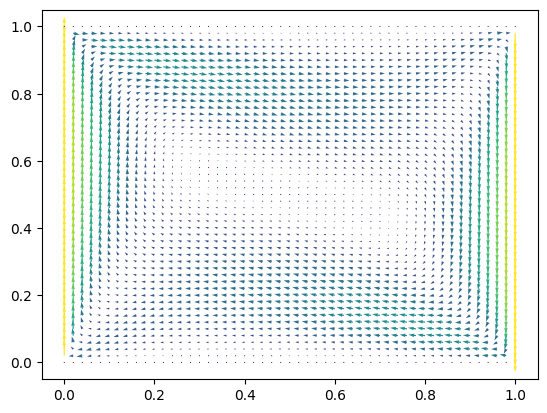

In [8]:
fd.quiver(fom.velocity)

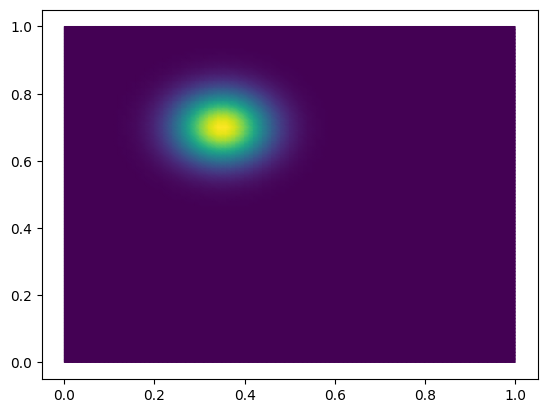

In [9]:
fd.tripcolor(fom.m_true)

In [10]:
sol_transient, grid_t = fom.implicit_Euler(
    m_init = fom.m_true,
    dt=0.1,
    final_time=10
)

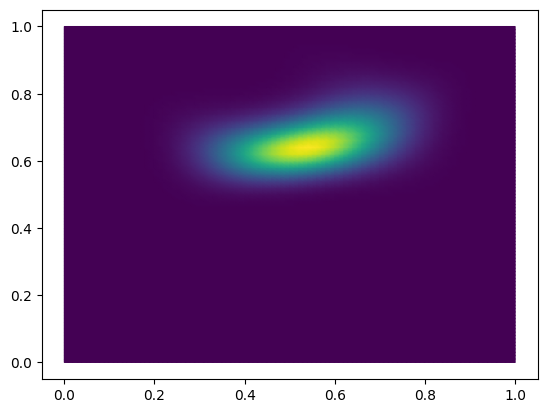

In [11]:
t = 0.8
k = np.argmin(np.abs(grid_t - t))
fd.tripcolor(sol_transient[k])

## Steady state

In [12]:
sol_steadystate = fom.solve_steady()

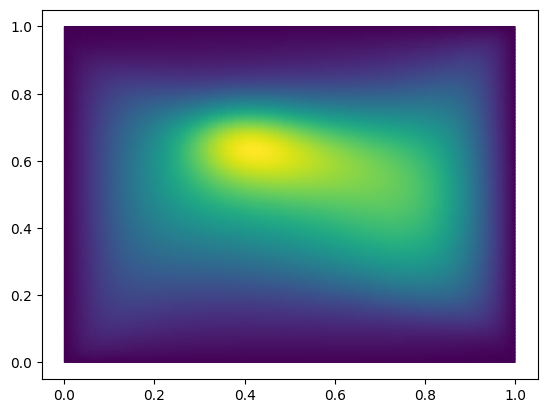

In [13]:
fd.tripcolor(sol_steadystate)

## Drone flies in a circle

In [14]:
class Drone():
    def __init__(
        self,
        fom,
        eval_mode="gaussian",
        fly_mode="circle",
        grid_t=None,
        flying_parameters=None,
        **kwargs
    ):
        self.fom = fom

        self.eval_mode = eval_mode
        self.fly_mode = fly_mode
        self.grid_t = grid_t if grid_t is not None else np.arange(0, 1, 1e-2)

        self.sigma_gaussian = kwargs.get("sigma_gaussian", 0.1)
        self.radius_uniform = kwargs.get("radius_uniform", 0.1)

        self.flying_parameters = flying_parameters if flying_parameters is not None else self.get_default_flying_paramters()
        self.V = fd.FunctionSpace(self.fom.mesh, "CG", 2)

    def get_default_flying_paramters(self):
        if self.fly_mode == "circle":
            flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.3
            }
            return flying_paramters

        raise RuntimeError(f"Invalid fly_mode={self.fly_mode} provided.")

    def get_trajectory(self, flying_parameters = None, grid_t = None):
        if flying_parameters is None:
            flying_parameters = self.flying_parameters

        center = flying_parameters["center"]
        radius = flying_parameters["radius"]
        speed = flying_parameters["speed"]

        if grid_t is None:
            grid_t = self.grid_t

        round_trip_time = 2 * np.pi * radius / speed
        angles = (grid_t * 2 * np.pi) / round_trip_time
        pos = radius * np.vstack([np.cos(angles), np.sin(angles)]).T
        pos = pos + center
        return pos, grid_t

    def measure(self, flightpath, state, mode=None, **kwargs):

        mode = mode if mode is not None else self.eval_mode

        if mode == "point-eval":
            return self.measure_pointwise(flightpath, state)

        if mode == "gaussian":
            return self.measure_gaussian(flightpath, state)

        if mode == "uniform":
            return self.measure_uniform(flightpath, state)

        raise RuntimeError(f"Invalid eval_mode={mode} encountered in Drone.measure")

    def measure_pointwise(self, flightpath, state):
        # TODO: this implementation assumes currently that a time-dependent state is on the same time-grid as the drone
        if isinstance(state, np.ndarray):
            return [state[k](flightpath[k, :]) for k in range(flightpath.shape[0])]

        return np.array([state(flightpath[k, :]) for k in range(flightpath.shape[0])])

    def measure_gaussian(self, flightpath, state):

        bool_transient = isinstance(state, np.ndarray)
        n_steps = flightpath.shape[0]
        data = np.NaN * np.ones((n_steps, ))

        for k in range(n_steps):

            pos_x, pos_y = flightpath[k, :]
            # Not sure about the best way to do this
            x, y = fd.SpatialCoordinate(self.fom.mesh)
            weight = fd.Function(self.V)
            weight_fct = weight.interpolate(
                fd.conditional(
                    fd.gt(
                        fd.exp(-0.5 * (pow(x - pos_x, 2) + pow(y - pos_y, 2)) / (self.sigma_gaussian ** 2)),
                        -np.exp(-1)
                    ),
                    fd.exp(-0.5 * (pow(x - pos_x, 2) + pow(y - pos_y, 2)) / (self.sigma_gaussian ** 2)),
                    -np.exp(-1)
                )
            )
            val_integral = fd.assemble(weight_fct * fd.Measure("dx", self.fom.mesh))
            
            weight_fct = weight.interpolate(
                fd.conditional(
                    fd.gt(
                        fd.exp(-0.5 * (pow(x - pos_x, 2) + pow(y - pos_y, 2)) / (self.sigma_gaussian ** 2)),
                        -np.exp(-1)
                    ),
                    fd.exp(-0.5 * (pow(x - pos_x, 2) + pow(y - pos_y, 2)) / (self.sigma_gaussian ** 2)) / val_integral,
                    -np.exp(-1) / val_integral
                )
            )
            # weight_fct = weight.interpolate(
            #     max(
            #         fd.exp(-0.5 * (pow(x - pos_x, 2) + pow(y - pos_y, 2)) / (self.sigma_gaussian ** 2)) / val_integral,
            #         -np.exp(-1) / val_integral
            #     )
            # )

            if bool_transient:
                val = fd.assemble(fd.inner(weight_fct, state[k]) * fd.dx)
            else:
                val = fd.assemble(fd.inner(weight_fct, state) * fd.dx)
            data[k] = val

        return data

    def measure_uniform(self, flightpath, state):

        bool_transient = isinstance(state, np.ndarray)
        n_steps = flightpath.shape[0]
        data = np.NaN * np.ones((n_steps, ))

        for k in range(n_steps):

            pos_x, pos_y = flightpath[k, :]
            x, y = fd.SpatialCoordinate(self.fom.mesh)
            weight = fd.Function(self.V)
            weight_fct = weight.interpolate(
                0.5 + 0.5 * (self.radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2))) / abs(self.radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2)))
            )
            val_integral = fd.assemble(weight_fct * fd.Measure("dx", self.fom.mesh))
            weight_fct = weight.interpolate(
                (0.5 + 0.5 * (self.radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2))) / abs(self.radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2)))) / val_integral
            )

            if bool_transient:
                val = fd.assemble(fd.inner(weight_fct, state[k]) * fd.dx)
            else:
                val = fd.assemble(fd.inner(weight_fct, state) * fd.dx)
            data[k] = val

        return data


In [15]:
# Set default flying parameters
flying_parameters = {
    "radius" : 0.25,
    "center" : np.array([0.75/2, 0.55/2]),
    "speed" : 0.3
}

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters)

In [16]:
# For playing with different flight path, you can specify them
# anew when asking for the trajectory
flying_parameters_temp = flying_parameters

pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters_temp)

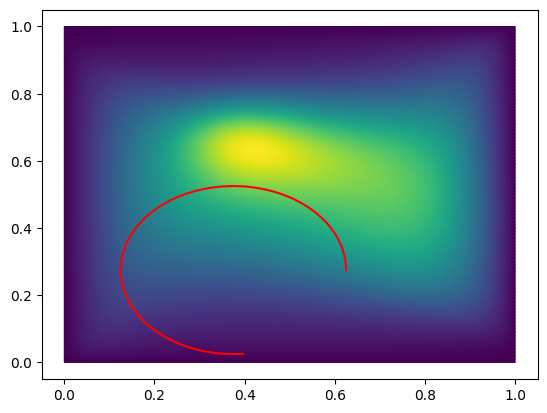

In [17]:
fd.tripcolor(sol_steadystate)
plt.plot(pos[:, 0], pos[:, 1], color="r")


 measurement steadystate:  0.03091179201668076
 point evaluation:         0.034264573629019794
 compute time:             0.17288517951965332  s 

 measurement transient:    0.08423423170310451
 point evaluation:         0.07718083741410353
 compute time:             0.0012080669403076172  s 



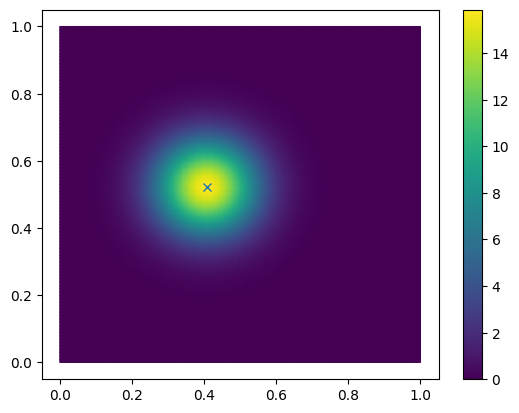

In [18]:
t = 1.2  # at which time should we take the measurment?
k = np.argmin(np.abs(grid_t - t))
pos_x, pos_y = pos[k, :]  # closest time step
sigma_gaussian = 0.1  # standard deviation of the gaussian functional
# measurement area will be cut off after 2*sigma_weight

# (unscaled) density function for normal distribution
# Don't know how to modify the interpolated function, so I think you have to interpolate again
x, y = fd.SpatialCoordinate(fom.mesh)
weight = fd.Function(fom.V)
weight_fct = weight.interpolate(
    fd.exp(-0.5 * (pow(x - pos_x, 2) + (pow(y - pos_y, 2))) / (sigma_gaussian ** 2))
)
val_integral = fd.assemble(weight_fct * fd.Measure("dx", fom.mesh))

weight_fct = weight.interpolate(
    fd.exp(-0.5 * (pow(x - pos_x, 2) + (pow(y - pos_y, 2))) / (sigma_gaussian ** 2)) / val_integral
)

fig, axes = plt.subplots()
colors = fd.tripcolor(weight_fct, axes = axes)
plt.plot([pos_x],[pos_y], marker = 'x')
fig.colorbar(colors)

tStart = time.time()
val_steadystate = fd.assemble(fd.inner(weight_fct, sol_steadystate) * fd.dx)
t_eval_steadystate = time.time() - tStart

tStart = time.time()
val_transient = fd.assemble(fd.inner(weight_fct, sol_transient[k]) * fd.dx)
t_eval_transient = time.time() - tStart

print("\n measurement steadystate: ", val_steadystate)
print(" point evaluation:        ", sol_steadystate([pos_x, pos_y]))
print(" compute time:            ", t_eval_steadystate, " s \n")


print(" measurement transient:   ", val_transient)
print(" point evaluation:        ", sol_transient[k]([pos_x, pos_y]))
print(" compute time:            ", t_eval_transient, " s \n")


 measurement steadystate:  0.0338016530498667
 point evaluation:         0.034264573629019794
 compute time:             0.0010349750518798828  s 

 measurement transient:    0.09737382636118291
 point evaluation:         0.07718083741410353
 compute time:             0.0004649162292480469  s 



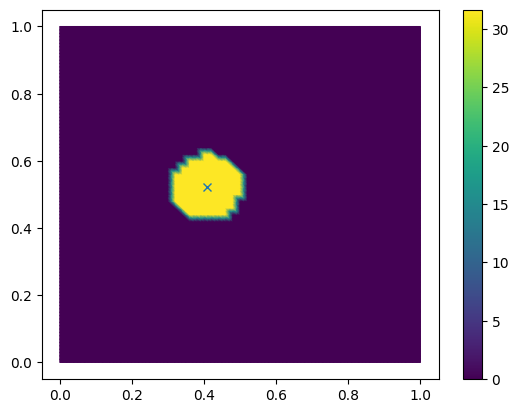

In [19]:
radius_uniform = sigma_gaussian

x, y = fd.SpatialCoordinate(fom.mesh)

weight = fd.Function(fom.V)
weight_fct = weight.interpolate(
    0.5 + 0.5 * (radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2))) / abs(radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2)))
)
val_integral = fd.assemble(weight_fct * fd.Measure("dx", fom.mesh))
weight_fct = weight.interpolate(
    (0.5 + 0.5 * (radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2))) / abs(radius_uniform ** 2 - (pow(x - pos_x, 2) + pow(y - pos_y, 2)))) / val_integral
)

fig, axes = plt.subplots()
colors = fd.tripcolor(weight_fct, axes = axes)
plt.plot([pos_x],[pos_y], marker = 'x')
fig.colorbar(colors)

tStart = time.time()
val_steadystate = fd.assemble(fd.inner(weight_fct, sol_steadystate) * fd.dx)
t_eval_steadystate = time.time() - tStart

tStart = time.time()
val_transient = fd.assemble(fd.inner(weight_fct, sol_transient[k]) * fd.dx)
t_eval_transient = time.time() - tStart

print("\n measurement steadystate: ", val_steadystate)
print(" point evaluation:        ", sol_steadystate([pos_x, pos_y]))
print(" compute time:            ", t_eval_steadystate, " s \n")


print(" measurement transient:   ", val_transient)
print(" point evaluation:        ", sol_transient[k]([pos_x, pos_y]))
print(" compute time:            ", t_eval_transient, " s \n")

In [20]:
slicer = 1

tStart = time.time()

d_steadystate_gaussian = drone.measure(pos[::slicer, :], sol_steadystate, mode="gaussian")
d_steadystate_pointwise = drone.measure(pos, sol_steadystate, mode="point-eval")
d_steadystate_uniform = drone.measure(pos[::slicer, :], sol_steadystate, mode="uniform")

print(f"Runtime for half this block: {(time.time()-tStart)/60} min")

d_transient_gaussian = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="gaussian")
d_transient_pointwise = drone.measure(pos, sol_transient, mode="point-eval")
d_transient_uniform = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="uniform")

print(f"Runtime for half this block: {(time.time()-tStart)/60} min")

/Users/tlynn/Code/twinOED/firedrake/src/ufl/ufl/exproperators.py:324: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


Runtime for half this block: 1.0619718194007874 min


/Users/tlynn/Code/twinOED/firedrake/src/ufl/ufl/exproperators.py:324: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/twinOED/firedrake/src/ufl/ufl/exproperators.py:324: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/twinOED/firedrake/src/ufl/ufl/exproperators.py:324: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/twinOED/firedrake/src/ufl/ufl/exproperators.py:324: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/twinOED/firedrake/src/ufl/ufl/exproperators.py:324: FutureWarning: elementwise comparison failed; retu

Runtime for half this block: 1.434352970123291 min


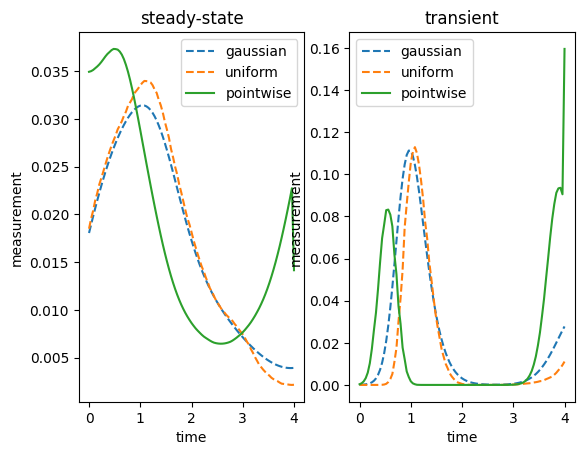

In [21]:
fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t[::slicer], d_steadystate_gaussian, label="gaussian", linestyle = "--")
axs[0].plot(grid_t[::slicer], d_steadystate_uniform, label="uniform", linestyle = "--")
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t[::slicer], d_transient_gaussian, label="gaussian", linestyle = "--")
axs[1].plot(grid_t[::slicer], d_transient_uniform, label="uniform", linestyle = "--")
axs[1].plot(grid_t, d_transient_pointwise, label="pointwise")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

In [22]:
t_notebook = time.time() - tStart_notebook
print("Runtime of this notebook: {} min".format(t_notebook / 60))

Runtime of this notebook: 2.1562804142634073 min
